<a href="https://colab.research.google.com/github/juhumkwon/Defense_Cloud/blob/main/9_0_1_PositionalEncoding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

# tf.range(position)[:, tf.newaxis] --> 결과 shape: (position, 1)
# tf.range(d_model)[tf.newaxis, :] --> 결과 shape: (1, d_model)
# 브로드캐스팅 후 곱해져서 → shape (position, d_model)인 angle matrix가 만들어집니다.
    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)

        # apply sin to even indices in the array (2i)
        sines = tf.math.sin(angle_rads[:, 0::2])

        # apply cos to odd indices in the array (2i+1)
        cosines = tf.math.cos(angle_rads[:, 1::2])


        angle_rads = np.zeros(angle_rads.shape) # angle_rads의 shape는 유지하지만, 내용은 전부 0이 됩니다.
        angle_rads[:, 0::2] = sines
        angle_rads[:, 1::2] = cosines
        pos_encoding = tf.constant(angle_rads) # "tf.constant(angle_rads)는 angle_rads를 TensorFlow tensor로 변환하여, 이후 TensorFlow 연산에 사용할 수 있게 만듭니다."
        pos_encoding = pos_encoding[tf.newaxis, ...] # (position, d_model) → (batch_size=1, position, d_model) 로 만들어주는

        print(pos_encoding.shape)
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        # Convert inputs to dense tensor if it's sparse
        # → 모델은 dense tensor 연산만 가능하기 때문에, 필요 시 dense tensor로 변환해줘야 합니다.
        if isinstance(inputs, tf.SparseTensor):
            inputs = tf.sparse.to_dense(inputs)
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

(1, 50, 128)


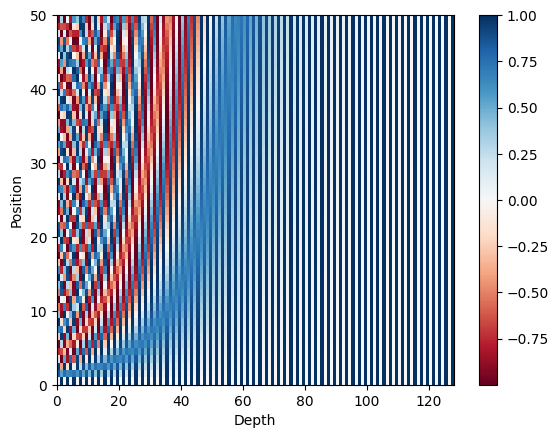

In [2]:
# 문장의 길이 50, 임베딩 벡터의 차원 128
sample_pos_encoding = PositionalEncoding(50, 128)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 128))
plt.ylabel('Position')
plt.colorbar()
plt.show()
